In [1]:
import numpy as np
import plotly.graph_objects as go
from itertools import combinations
from operator import concat
import igraph
import Surfaces
import TwoMapper
from gtda.mapper import (
    CubicalCover,
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph,
    MapperInteractivePlotter,
    nerve
)
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from functools import reduce

from Giotto2Mapper import (two_dim_nerve, two_mapper)

## Circular Cover

Currently, with `giotto-tda` there is only one cover option which is the `gtda.mapper.CubicalCover`. This cover is generated as cartesian products of intervals. A consquence of this is that when taking a filter $f\colon X\to \mathbb{R}^2$ with `CubicalCover` is that there are oppurtunities for **4-fold** intersections, and **not 3-fold intersections**. This means `Giotto2Mapper.two_dim_nerve` in its current state is finding 4-fold intersections and marking them as 3-fold intersections. This is not ideal, and so we should use a different cover structure to find distinct 3-fold intersections when covering the image of our dataset under our filter $f(X)\subseteq\mathbb{R}^2$.

We will go ahead and construct such a cover. This cover will be a 'circular cover' where each open set in the cover is a circle centered on a trianglular lattice. The resulting overlapping circles will have [this appearence](https://en.wikipedia.org/wiki/Overlapping_circles_grid#Triangular_grid_of_overlapping_circles).

#### We first have a triangular lattice.
We will use this triangluar lattice as our base point for constructing our cover. We will also begin to only work with the 'uniform' option of cover where each open set in the cover is the same size.


1. **COMPLETE** Properly shift the lattice to cover $f(X)$.
2. **COMPLETE** Construct lattice to have specified number of bins and correct gain (percentage overlap).
3. **COMPLETE** Make sure output matches the format in the `giotto-tda` files `gtda.mapper.cover.py`.
### **TO DO**
4. Get the test file to actually run.
5. (optional) Extend circular cover for $n$-dimensional filters where $n>2$ (This is probably quite challenging).
6. (optional) Create a 'balanced' option for the circular cover.

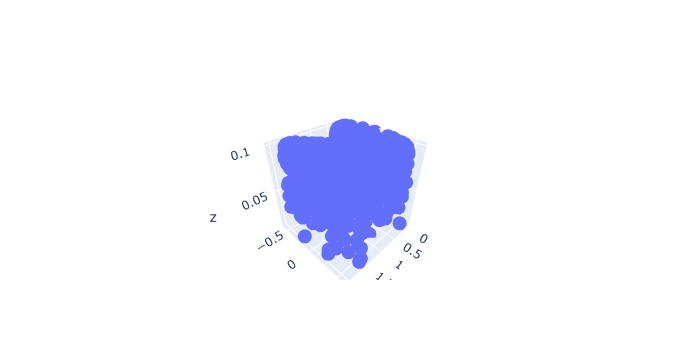

In [65]:
data = np.array(Surfaces.sample_g2torus(1000))
torus_graph = Surfaces.graph_sample(data)

In [66]:
# Define filter function – can be any scikit-learn transformer
filter_func = Projection(columns=[0, 1])
# Define cover
cover = CubicalCover(n_intervals=10, overlap_frac=0.3)
# Choose clustering algorithm – default is DBSCAN
clusterer = DBSCAN()

### Generate Cover Output by Hand.

In [67]:
filtered_data = filter_func.fit_transform(data)
filtered_data.ndim

2

In [5]:
covered_data = cover.fit_transform(filtered_data)

In [6]:
covered_data.shape

(1000, 84)

We see that the above cover output is an array of booleans whose shape is `(n_samples,n_coversets)`. 

Note that `n_coversets` is less than `n_intervals` squared (by default 100), as empty or repeated covers are deleted.

## Begin with a simple best copy from `giotto-tda`.

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted
from gtda.utils.validation import validate_params
from gtda.utils.intervals import Interval
import warnings
from gtda.mapper.utils._cover import (_check_has_one_column, _remove_empty_and_duplicate_intervals)

'Add to _cover.py'
def _check_has_two_columns(X):
    if X.shape[1] != 2:
        raise ValueError(f"X must have two columns. Currently X has {X.shape[1]} columns.")

class CircularCover(BaseEstimator, TransformerMixin):
    # Parameters
    _hyperparameters = {
        'kind': {'type': str, 'in': ['uniform']},
        'n_intervals': {'type': int, 'in': Interval(1, np.inf, closed='left')},
        'overlap_frac': {'type': float, 'in': Interval(0, 1, closed='neither')}
        }
    '''
    Attributes
    ----------
    coord1_limits_ : ndarray of shape (2,)
        Limits of the bounding box on the coord1 (x) axis computed in :meth: `fit`.
    
    coord2_limits_ : ndarray of shape (2,)
        Limits of the bounding box on the coord2 (y) axis computed in :meth: `fit`.
    
    ball_centers_ : ndarray (shape (n_intervals*??,)) 
        Centers of every ball in the cover. The number of balls in the cover are
        dependent on `overlap_frac`, `n_intervals`, coord1_limits_, and coord2_limits_
    
    ball_radius_ : float
        The radius for each ball in the circular cover.
        
    '''
    
    def __init__(self, kind = 'uniform', n_intervals = 10, overlap_frac = 0.1):
        self.kind = kind
        self.n_intervals = n_intervals
        self.overlap_frac = overlap_frac
    
    def _fit_uniform(self, X):
        self.coord1_limits_, self.coord2_limits_ = self._find_bounding_box(
            X, self.n_intervals, is_uniform = True)
        self.ball_centers_, self.ball_radius_ = self._circular_cover_limits(
            self.coord1_limits_[0], self.coord1_limits_[1], self.coord2_limits_[0],
            self.coord2_limits_[1], self.n_intervals, self.overlap_frac)
        return self
    
    def fit(self, X, y=None):
        
        X = check_array(X)
        # validate_params(self.get_params(), self.hyperparameters)
        if self.overlap_frac <= 1e-8:
            warnings.warn("`overlap_frac` is close to zero, "
                          "which might cause numerical issues and errors.",
                          RuntimeWarning)
        if X.ndim == 2:
            _check_has_two_columns(X)
            
        is_uniform = self.kind == 'uniform'
        # Can add `balanced` version later
        if is_uniform:
            fitter = self._fit_uniform 
        return fitter(X)
    
    def _transform(self, X):
        bools = []
        for data in X:
            dist_bools = [np.linalg.norm(data-center) < self.ball_radius_ for center in self.ball_centers_]
            bools.append(dist_bools)
        bools = np.asarray(bools)
        return bools
    
    def transform(self, X, y=None):
        check_is_fitted(self)
        Xt = check_array(X)
        
        if Xt.ndim == 2:
            _check_has_two_columns(Xt)
        
        Xt = self._transform(Xt)
        Xt = _remove_empty_and_duplicate_intervals(Xt)
        return Xt
    
    def _fit_transform(self, X):
        if self.kind == 'uniform':
            Xt = self._fit_uniform(X)._transform(X)
        return Xt
    
    def fit_transform(self, X, y=None, **fit_params):
        Xt = check_array(X)
        validate_params(self.get_params(), self._hyperparameters)
        
        if Xt.ndim == 2:
            _check_has_two_columns(Xt)
        Xt = self._fit_transform(Xt)
        Xt = _remove_empty_and_duplicate_intervals(Xt)
        return Xt
    
    def _find_bounding_box(self, X, n_intervals, is_uniform=True):
        if is_uniform:
            coord1_min_val, coord1_max_val = np.min(X[:,0]), np.max(X[:,0])
            coord2_min_val, coord2_max_val = np.min(X[:,1]), np.max(X[:,1])
            coord_list = [coord1_min_val, coord1_max_val, coord2_min_val, coord2_max_val]
            only_one_pt = all( _ == coord_list[0] for _ in coord_list)
        else:
            raise ValueError("Circular cover can only be uniformly computed at this time")
        if only_one_pt and n_intervals > 1:
            raise ValueError(
                f"Only one unique filter value found, cannot fit "
                f"{n_intervals} > 1 intervals.")
        
        return np.asarray(coord_list[:2]), np.asarray(coord_list[2:4])
        
    
    @staticmethod
    def _circular_cover_limits(x_min, x_max, y_min, y_max, n_intervals, overlap_frac):
        ''' We build a triangular lattice which will be the centers of each circle in the cover
            This lattice allows us to have distinct 3-fold intersections of of open sets in our
            cover.
        '''
        # Compute the radius, dx, and dy
        x_len = (x_max - x_min)/n_intervals
        y_len = float((np.sqrt(3)/2)*x_len)
        radius = (0.5 + overlap_frac)*x_len
        
        # Find ball centers on the even rows of the lattice
        even_rows = np.arange(x_min - 0.5*x_len, x_max + 0.5*x_len, x_len)
        even_cols = np.arange(y_min, y_max + y_len, 2*y_len)
        xeven, yeven = np.meshgrid(even_rows, even_cols)
        even_center_list = np.vstack(list(zip(xeven.ravel(), yeven.ravel())))
        
        # Find ball centers on the odd rows of the lattice
        odd_rows = np.arange(x_min, x_max + x_len, x_len)
        odd_cols = np.arange(y_min, y_max + y_len, 2*y_len)
        xodd, yodd = np.meshgrid(odd_rows, odd_cols)
        odd_center_list = np.vstack(list(zip(xodd.ravel(),yodd.ravel())))
        
        # Combine and sort the centers list via the 2-norm
        center_list = np.concatenate((even_center_list,odd_center_list), axis = 0)
        sorted_index = np.argsort(np.linalg.norm(center_list, axis = 1))
        center_list = center_list[sorted_index]
        
        return center_list, radius

## Test the Class!!

In [68]:
circle_cover = CircularCover(n_intervals = 10, overlap_frac = 0.5)
circle_fit = circle_cover.fit(filtered_data)
circle_covered_data = circle_cover.fit_transform(filtered_data)
print(circle_covered_data.shape, circle_fit.ball_centers_.shape, circle_fit.ball_radius_)

(1000, 82) (88, 2) 0.20646581389114066


In [77]:
circle_fit.ball_centers_[:3]

array([[-0.02806345,  0.13299255],
       [ 0.07516945,  0.13299255],
       [-0.13129636,  0.13299255]])

In [69]:
ccd = circle_fit.transform(filtered_data)
ccd = _remove_empty_and_duplicate_intervals(ccd)
np.testing.assert_array_almost_equal(ccd, circle_covered_data)

In [71]:
interval_masks = circle_cover.fit_transform(filtered_data)
intervals = []
for i in range(interval_masks.shape[1]):
    intervals.extend(filtered_data[interval_masks[:, i]])
unique_points = np.unique(intervals, axis=0)
unique_filtered_data = np.unique(filtered_data, axis=0)
np.testing.assert_almost_equal(unique_points, unique_filtered_data)

In [72]:
pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=circle_cover,
    clusterer=DBSCAN(),
    verbose=False,
    n_jobs=1,
    store_edge_elements=True
)

In [73]:
graph = pipe.fit_transform(data)

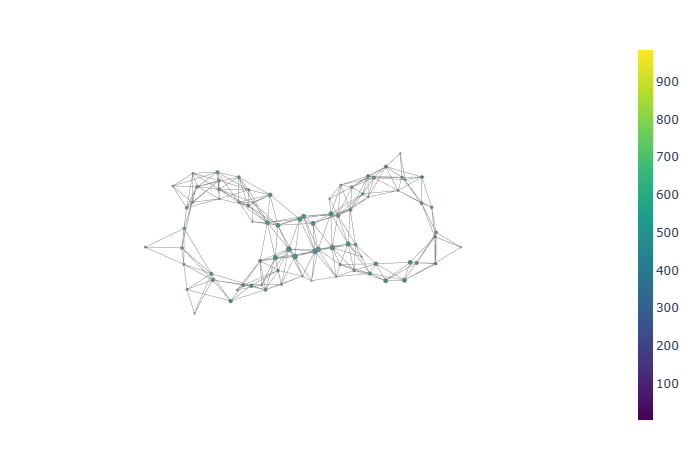

In [74]:
fig = plot_static_mapper_graph(pipe, data, layout_dim=3)
fig.show()

In [78]:
two_fig = two_mapper(graph, fig)

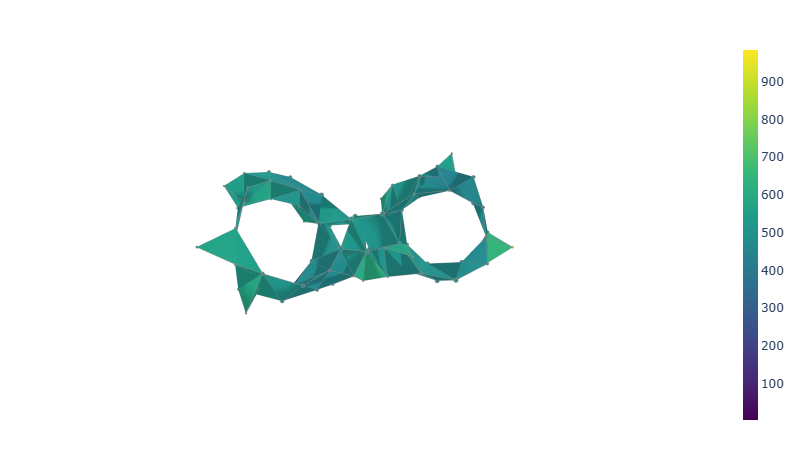

In [79]:
two_fig.show()

In [ ]:
big_data = Surfaces.sample_torus(10000)
big_graph = pipe.fit_transform(big_data)
big_fig = plot_static_mapper_graph(pipe, big_data, layout_dim=3)
big_fig.show()

In [ ]:
two_big_fig = two_mapper(big_graph, big_fig)
two_big_fig.show()

## JK Lets write up our new lattice to see if it works
It does!

In [ ]:
# Data stats and params
xmin = np.min(filtered_data[:,0])
xmax = np.max(filtered_data[:,0])
ymin = np.min(filtered_data[:,1])
ymax = np.max(filtered_data[:,1])
gain = 0.1
n_intervals = 10

# Find radius r and interval lengths xl and yl
xl = (xmax - xmin)/n_intervals
yl = float((np.sqrt(3)/2)*xl)
radius = (0.5+gain)*xl

'We need two seperate mesh grids for even and odd rows'
even_rows = np.arange(xmin-0.5*xl, xmax+0.5*xl, xl)
even_cols = np.arange(ymin, ymax+yl, 2*yl)
odd_rows = np.arange(xmin, xmax+xl, xl)
odd_cols = np.arange(ymin+yl, ymax+yl, 2*yl)
' We then can construct a mesh grid of each for our triangle lattice centers '
'WE DONT NEED MESHGRID'
xeven, yeven = np.meshgrid(even_rows,even_cols)
xodd, yodd = np.meshgrid(odd_rows, odd_cols)

In [ ]:
dy = (ymax-ymin)/yl
len(even_rows), len(odd_rows), len(even_cols), len(odd_cols)
xl,2*yl

In [ ]:
# plt.plot(xeven,yeven, marker = 'o', linestyle = 'none', color = 'r')
# plt.plot(xodd,yodd, marker = 'o', linestyle = 'none', color = 'r')

In [ ]:
# Distance between 2 circle centroids:
2*radius-(2*gain*xl), xl

In [ ]:
'Verify that neighboring points in the grid have this distance'
point1 = np.asarray([even_rows[0], even_cols[0]])
point2 = np.asarray([odd_rows[0],odd_cols[0]])
point3 = np.asarray([even_rows[1], even_cols[0]])
point4 = np.asarray([odd_rows[1],odd_cols[0]])
print(point1,point2,point3,point4)
print(np.linalg.norm([point1-point2]),
      np.linalg.norm([point4-point1]),
      np.linalg.norm([point2-point4]))
f = go.Figure()
f.add_trace(go.Scatter(x=[point1[0],point2[0],point3[0],point4[0]], y=[point1[1],point2[1],point3[1],point4[1]], mode='markers'))
f.show()    

In [ ]:
# Construct the meshgrid as a list of tuples
# Order the list by norm
even_center_list = np.vstack(list(zip(xeven.ravel(),yeven.ravel())))
odd_center_list = np.vstack(list(zip(xodd.ravel(),yodd.ravel())))
center_list = np.concatenate((even_center_list,odd_center_list), axis=0)
sorted_index = np.argsort(np.linalg.norm(center_list, axis=1))
center_list = center_list[sorted_index]

In [ ]:
'Plot the cover circles'
fig = go.Figure()
fig.add_trace(go.Scatter(x=filtered_data[:,0],y=filtered_data[:,1],mode='markers'))
fig.add_trace(go.Scatter(x=center_list[:,0], y=center_list[:,1], mode='markers'))

In [ ]:
for point in center_list:
    fig.add_shape(type='circle', x0=point[0]-radius,x1=point[0]+radius,
                  y0=point[1]-radius,y1=point[1]+radius)

In [ ]:
fig.show()

In [ ]:
# Now check if data is in a ball in the cover or not
# emulate _transform
bools = []
for data in filtered_data:
    dist_bools = [np.linalg.norm(data-center)<radius for center in center_list]
    bools.append(dist_bools)
bools = np.asarray(bools)

In [ ]:
bools.shape